## New York City Taxi Dataset 2013

This notebook contains Data Modelling for predicting Trip Fares after Data Cleaning is done and both the trip data and fare data for October 2013 is merged into one dataset. For prediction I have used Neural Network models from keras and tensorflow

In [1]:
# !pip3 install seaborn

### Importing the required libraries

In [2]:
import pandas as pd

import geopy
import geopy.distance as gd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import matplotlib.pyplot as plt
import plotly_express as px
import seaborn as sns

import math
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xg

from scipy import stats

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU

### Reading data from the cleaned and merged new york taxi data using pandas

In [3]:
taxi_trip_df = pd.read_csv('/data/shared/debdeep_guha/nyc_taxi_data/cleaned_full_taxi_data.csv')

In [4]:
taxi_trip_df.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,trip_dist_miles,trip_diff_seconds,avg_speed,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,740BD5BE61840BE4FE3905CC3EBE3E7E,E48B185060FB0FF49BE6DA43E69E624B,CMT,1,2013-10-01 12:44:29,2013-10-01 12:53:26,1,536,1.2,-73.974319,...,0.884191,537.0,8.044693,CRD,8.0,0.0,0.5,2.1,0.0,10.6
1,EA05309C30F375695F44C96108ACB10F,1D10D8AC5B07D80861761365A05A9AE2,CMT,1,2013-10-02 19:44:55,2013-10-02 20:03:55,1,1139,5.1,-73.981239,...,2.075469,1140.0,16.105263,CRD,18.0,1.0,0.5,3.0,0.0,22.5
2,EA05309C30F375695F44C96108ACB10F,1D10D8AC5B07D80861761365A05A9AE2,CMT,1,2013-10-02 22:01:18,2013-10-02 22:09:18,1,480,2.2,-74.002991,...,0.454633,480.0,16.500000,CRD,9.5,0.5,0.5,2.1,0.0,12.6
3,B36D7AB5B422EA1A0588EFD1D8155EF3,669F420B42A0739A5D1058184AD227ED,CMT,1,2013-10-03 12:14:35,2013-10-03 12:26:04,1,689,0.9,-73.967178,...,0.889170,689.0,4.702467,CRD,8.5,0.0,0.5,1.8,0.0,10.8
4,28172009F5513B25F4091C0929C4515D,ABE08BCFEBF3F5F7339CA2170EEC1DEE,CMT,1,2013-10-02 00:33:37,2013-10-02 01:06:16,1,1959,14.8,-73.784142,...,10.234611,1959.0,27.197550,CRD,43.0,0.5,0.5,11.0,0.0,55.0


In [5]:
# checking the column names in the dataset
taxi_trip_df.columns

Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_time_in_secs', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'trip_dist_miles', 'trip_diff_seconds', 'avg_speed', 'payment_type',
       'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount',
       'total_amount'],
      dtype='object')

In [6]:
# checking the length of the dataset
len(taxi_trip_df)

13895209

In [7]:
# the datatypes of all the columns in the dataset
taxi_trip_df.dtypes

medallion             object
hack_license          object
vendor_id             object
rate_code              int64
pickup_datetime       object
dropoff_datetime      object
passenger_count        int64
trip_time_in_secs      int64
trip_distance        float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
trip_dist_miles      float64
trip_diff_seconds    float64
avg_speed            float64
payment_type          object
fare_amount          float64
surcharge            float64
mta_tax              float64
tip_amount           float64
tolls_amount         float64
total_amount         float64
dtype: object

#### Converting `dropoff_datetime` and `pickup_datetime` into datetime from type object

In [8]:
taxi_trip_df['dropoff_datetime'] =  pd.to_datetime(taxi_trip_df['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_trip_df['pickup_datetime'] =  pd.to_datetime(taxi_trip_df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

#### Extracting the day, hour and weekday number

In [9]:
taxi_trip_df['pickup_weekday'] = taxi_trip_df['pickup_datetime'].dt.dayofweek
taxi_trip_df['pickup_hour'] = taxi_trip_df['pickup_datetime'].dt.hour
taxi_trip_df['pickup_day'] = taxi_trip_df['pickup_datetime'].dt.day

#### Fare Amount Distribution

/home/ml/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 0, 'Fare Amount Distribution')

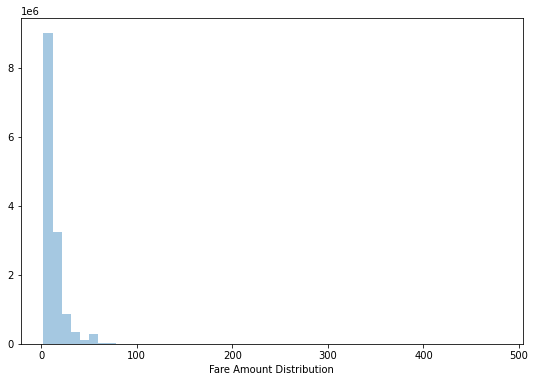

In [10]:
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.distplot(taxi_trip_df['fare_amount'], kde=False)
ax.set_xlabel('Fare Amount Distribution')

In [11]:
# checking the maximum fare amount
taxi_trip_df['fare_amount'].max()

480.0

In [12]:
# checking other values for the maximum fare amount
taxi_trip_df[taxi_trip_df['fare_amount'] == taxi_trip_df['fare_amount'].max()]

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_weekday,pickup_hour,pickup_day
12931885,C85F202D4400ACD406CB4DE6850A0EDB,32379D76A4C3FB946DADD3F2866E8C6B,CMT,5,2013-10-04 00:50:20,2013-10-04 00:51:08,1,47,0.1,-74.015343,...,CRD,480.0,0.0,0.0,0.0,0.0,480.0,4,0,4


In [13]:
taxi_trip_df[taxi_trip_df['fare_amount'] == taxi_trip_df['fare_amount'].max()]['trip_diff_seconds']

12931885    48.0
Name: trip_diff_seconds, dtype: float64

In [14]:
# checking the top 50 highest fare amount values
taxi_trip_df.sort_values(by=['fare_amount'], ascending=False)['total_amount'].head(50)

12931885    480.00
13122835    450.01
2549028     450.01
9072835     450.00
6547134     479.50
11683802    450.50
9777392     424.11
295038      385.00
8701168     380.50
13654879    375.00
10518088    370.00
336286      360.00
3484026     350.00
4048436     350.00
6050315     325.00
533386      326.33
8890412     300.00
3671056     300.00
1969898     315.00
10486355    300.50
4616019     300.64
2557831     280.00
5526420     336.00
12774741    350.00
5393949     336.00
3053796     275.00
5432854     270.00
3734727     259.25
12389903    255.33
5196860     258.71
365482      240.00
5010480     250.75
1522900     284.40
8129431     241.83
785089      233.00
7754389     280.00
6177601     225.00
1929962     238.25
6188218     238.30
1234514     264.00
4417664     225.33
8467868     242.00
2820307     245.32
13057037    215.50
4249421     224.33
11786347    228.50
9032641     210.25
2674588     230.66
2051583     200.00
5751836     200.50
Name: total_amount, dtype: float64

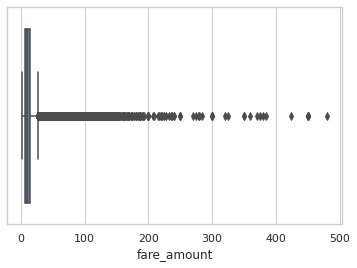

In [15]:
# the boxplot below shows a lot of outliers
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=taxi_trip_df["fare_amount"])

In [16]:
# checking the number of records that will be removed if stdev of 4 is selected
taxi_trip_df[(np.abs(stats.zscore(taxi_trip_df['fare_amount'])) > 4)]

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_weekday,pickup_hour,pickup_day
189,FB44AC801A5E0C646781C90C3F9DFB56,11A6677A48CF6D3C17FA3F18AD4A68AC,CMT,3,2013-10-10 16:37:07,2013-10-10 17:17:49,1,2442,17.0,-73.980911,...,CRD,67.5,1.0,0.0,15.20,16.30,100.00,3,16,10
221,F605E00E7F30EA8A192451B8C3558DF2,5FC6FB04951DC550B958E6CDC1F0B992,CMT,1,2013-10-12 15:21:38,2013-10-12 16:19:59,1,3500,25.4,-74.008965,...,CRD,72.5,0.0,0.5,14.60,0.00,87.60,5,15,12
940,3519845B181E2C0C603FF23A320A1718,DF46CE34589E2AA3251F4F55DC80C71A,CMT,3,2013-10-09 11:42:40,2013-10-09 12:38:49,1,3369,18.9,-73.965759,...,CRD,80.0,0.0,0.0,15.00,12.85,107.85,2,11,9
975,5DB04ACE041C02E42BC57A25FF037AFA,6972A2B75B1963488B944F9B956D50A1,CMT,1,2013-10-08 16:13:29,2013-10-08 17:37:53,2,5064,10.7,-73.985573,...,CRD,58.5,1.0,0.5,12.00,0.00,72.00,1,16,8
1051,1573B667872D77E8130DB3A06A6975A7,30D8804C7CC2FD096389A05C3D29CB26,CMT,1,2013-10-13 13:56:35,2013-10-13 14:43:20,1,2805,19.3,-73.788979,...,CRD,54.0,0.0,0.5,13.62,0.00,68.12,6,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13894688,AA61AF12089DFE53ED13E67F0A42120A,2C584442C9DC6740767CDE5672C12379,CMT,1,2013-10-09 23:37:03,2013-10-10 00:11:15,1,2051,19.2,-73.982285,...,CRD,53.5,0.5,0.5,15.50,7.50,77.50,2,23,9
13894718,DBA15F7F35F853A32486CE789D7C0499,3871B106F70A201F76E2E82A5C0735DF,CMT,5,2013-10-10 23:08:38,2013-10-10 23:18:57,1,618,3.3,-73.997696,...,CRD,60.0,0.0,0.0,0.00,0.00,60.00,3,23,10
13894795,F09F782FAC8A0139ED3ACCB1AABA0689,A16383213C8C356120F2436E26963C40,CMT,5,2013-10-07 22:57:38,2013-10-07 23:14:29,1,1010,6.1,-73.984978,...,CRD,55.0,0.0,0.0,0.00,10.00,65.00,0,22,7
13895111,FE03F0961C73A4589ED4C40DFC60E771,90460D3132B627B0D04B17CA8DE772B9,CMT,1,2013-10-09 21:08:17,2013-10-09 21:43:21,1,2104,23.0,-73.776848,...,CRD,61.0,0.5,0.5,10.00,0.00,72.00,2,21,9


In [17]:
# keeping records which lie within the 4th standard deviation using z-score
upd_taxi_trip_df = taxi_trip_df[(np.abs(stats.zscore(taxi_trip_df['fare_amount'])) < 4)]

In [18]:
upd_taxi_trip_df.reset_index(drop=True, inplace=True)

In [19]:
upd_taxi_trip_df

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_weekday,pickup_hour,pickup_day
0,740BD5BE61840BE4FE3905CC3EBE3E7E,E48B185060FB0FF49BE6DA43E69E624B,CMT,1,2013-10-01 12:44:29,2013-10-01 12:53:26,1,536,1.2,-73.974319,...,CRD,8.0,0.0,0.5,2.10,0.0,10.60,1,12,1
1,EA05309C30F375695F44C96108ACB10F,1D10D8AC5B07D80861761365A05A9AE2,CMT,1,2013-10-02 19:44:55,2013-10-02 20:03:55,1,1139,5.1,-73.981239,...,CRD,18.0,1.0,0.5,3.00,0.0,22.50,2,19,2
2,EA05309C30F375695F44C96108ACB10F,1D10D8AC5B07D80861761365A05A9AE2,CMT,1,2013-10-02 22:01:18,2013-10-02 22:09:18,1,480,2.2,-74.002991,...,CRD,9.5,0.5,0.5,2.10,0.0,12.60,2,22,2
3,B36D7AB5B422EA1A0588EFD1D8155EF3,669F420B42A0739A5D1058184AD227ED,CMT,1,2013-10-03 12:14:35,2013-10-03 12:26:04,1,689,0.9,-73.967178,...,CRD,8.5,0.0,0.5,1.80,0.0,10.80,3,12,3
4,28172009F5513B25F4091C0929C4515D,ABE08BCFEBF3F5F7339CA2170EEC1DEE,CMT,1,2013-10-02 00:33:37,2013-10-02 01:06:16,1,1959,14.8,-73.784142,...,CRD,43.0,0.5,0.5,11.00,0.0,55.00,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13836677,3FD555B8EA958A8AC0A50FCBEDED5CE2,A59A74F32FDFB59430AAC596A2B54FA6,CMT,1,2013-10-07 20:24:34,2013-10-07 20:30:22,1,347,1.0,-73.968300,...,CRD,6.0,0.5,0.5,1.00,0.0,8.00,0,20,7
13836678,F72C82AFFA243C164EA00B43398EDFCD,1B8B820092E36B6BDEF66B2B836A5E1F,CMT,1,2013-10-08 17:34:04,2013-10-08 17:42:27,3,502,1.1,-73.985168,...,CRD,7.0,1.0,0.5,2.10,0.0,10.60,1,17,8
13836679,400E7547B850AB2C980B02293A279988,265712C4B013561E39DA4EF5700BC8F0,CMT,1,2013-10-09 21:56:46,2013-10-09 22:03:43,1,416,1.8,-73.998978,...,CRD,8.0,0.5,0.5,1.80,0.0,10.80,2,21,9
13836680,C612423A09BF7298B817EBB674E7DC11,F3E5CC66E8544AF5FF67DFB70B6A7481,CMT,1,2013-10-10 02:11:50,2013-10-10 02:17:49,1,359,1.1,-73.985756,...,CRD,6.5,0.5,0.5,1.50,0.0,9.00,3,2,10


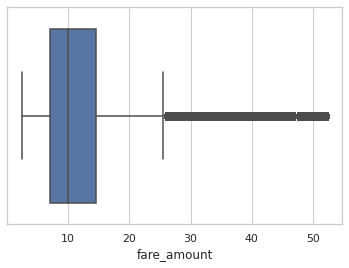

In [20]:
# a much better box plot
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=upd_taxi_trip_df["fare_amount"])

/home/ml/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 0, 'Fare Amount Distribution')

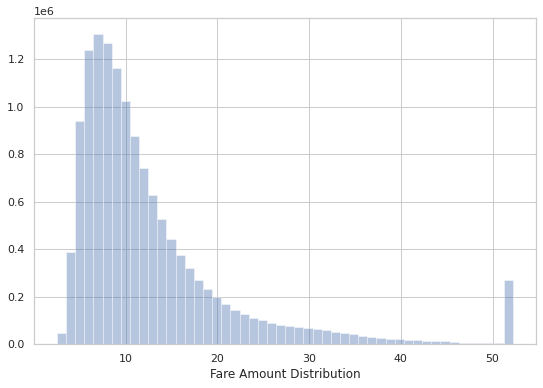

In [21]:
# checking the distribution after removing those records
fig, ax = plt.subplots(figsize=(9,6))
ax = sns.distplot(upd_taxi_trip_df['fare_amount'], kde=False)
ax.set_xlabel('Fare Amount Distribution')

### Feature Importance using Correlation

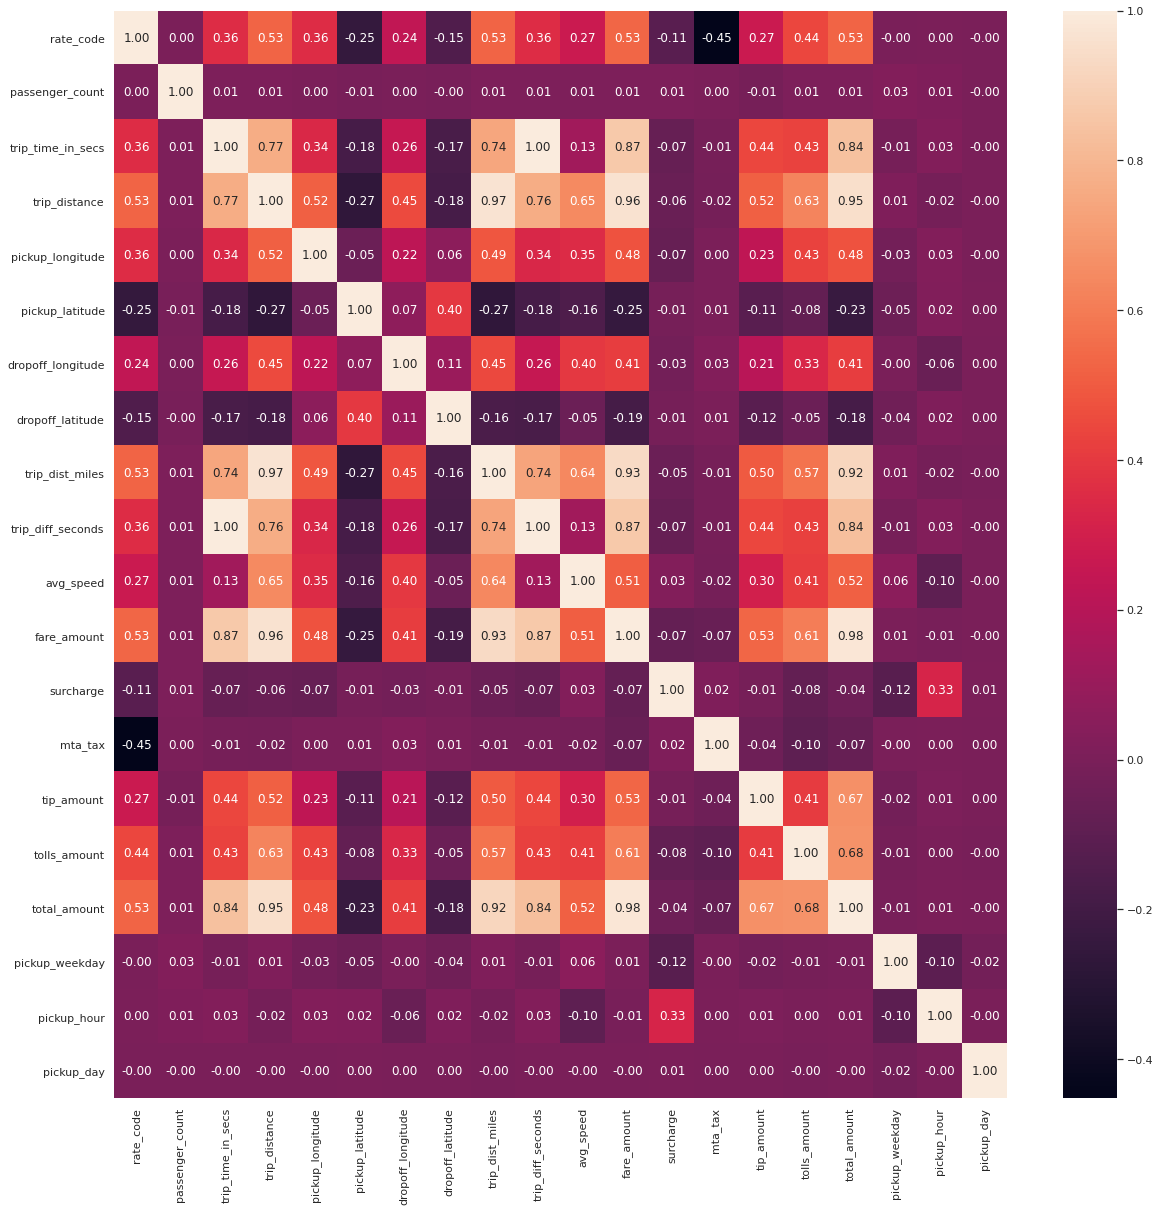

In [22]:
fig, ax = plt.subplots(figsize=(20,20))  
sns.heatmap(upd_taxi_trip_df.corr(), annot=True, fmt=".2f", ax=ax)
plt.show()

The most important features for predicting fare amount are:
- trip_distance (The distance travelled between pickup and dropoff locations)
- trip_diff_seconds (The time in seconds between pickup and dropoff datetime)
- total_amount ( The total amount incurred for the trip)

We may have to remove `total_amount` from the features as it might be too influential in predicting the `fare_amount`. `total_amount` is basically the summation of all the amounts incurred as part of the trip.

### Feature Engineering

Here we have to remove certain unnecessary columns, convert categorical columns into dummy columns (like one-hot encoding them), scale all the numerical columns within a certain range.

In [23]:
upd_taxi_trip_df.columns

Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_time_in_secs', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'trip_dist_miles', 'trip_diff_seconds', 'avg_speed', 'payment_type',
       'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount',
       'total_amount', 'pickup_weekday', 'pickup_hour', 'pickup_day'],
      dtype='object')

In [24]:
for cols in upd_taxi_trip_df.columns:
    print('Number of unique values in %s is %s' %(cols, len(upd_taxi_trip_df[cols].unique())))

Number of unique values in medallion is 13299
Number of unique values in hack_license is 33191
Number of unique values in vendor_id is 2
Number of unique values in rate_code is 6
Number of unique values in pickup_datetime is 2279355
Number of unique values in dropoff_datetime is 2281415
Number of unique values in passenger_count is 6
Number of unique values in trip_time_in_secs is 6787
Number of unique values in trip_distance is 3391
Number of unique values in pickup_longitude is 31849
Number of unique values in pickup_latitude is 59571
Number of unique values in dropoff_longitude is 44230
Number of unique values in dropoff_latitude is 82196
Number of unique values in trip_dist_miles is 13758563
Number of unique values in trip_diff_seconds is 7092
Number of unique values in avg_speed is 303201
Number of unique values in payment_type is 5
Number of unique values in fare_amount is 232
Number of unique values in surcharge is 28
Number of unique values in mta_tax is 2
Number of unique valu

#### Dropping 'medallion', 'hack_license', 'pickup_datetime', 'dropoff_datetime', 'trip_time_in_secs', 'trip_dist_miles' columns

In [25]:
drop_columns = ['medallion', 'hack_license', 'pickup_datetime', 'dropoff_datetime', 'trip_time_in_secs', 'trip_dist_miles']
upd_taxi_trip_df = upd_taxi_trip_df.drop(drop_columns, axis = 1)

In [26]:
upd_taxi_trip_df.columns

Index(['vendor_id', 'rate_code', 'passenger_count', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_diff_seconds', 'avg_speed', 'payment_type',
       'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount',
       'total_amount', 'pickup_weekday', 'pickup_hour', 'pickup_day'],
      dtype='object')

In [27]:
upd_taxi_trip_df.dtypes

vendor_id             object
rate_code              int64
passenger_count        int64
trip_distance        float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
trip_diff_seconds    float64
avg_speed            float64
payment_type          object
fare_amount          float64
surcharge            float64
mta_tax              float64
tip_amount           float64
tolls_amount         float64
total_amount         float64
pickup_weekday         int64
pickup_hour            int64
pickup_day             int64
dtype: object

#### Converting 'vendor_id', 'rate_code', 'passenger_count', 'payment_type', 'pickup_weekday', 'pickup_hour', 'pickup_day' into dummy variables

In [28]:
categorical_columns = ['vendor_id', 'rate_code', 'passenger_count', 'payment_type', 'pickup_weekday', 'pickup_hour', 
                       'pickup_day']

upd_taxi_trip_df = pd.get_dummies(upd_taxi_trip_df, columns=categorical_columns)

In [29]:
upd_taxi_trip_df.columns

Index(['trip_distance', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_diff_seconds',
       'avg_speed', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount',
       'tolls_amount', 'total_amount', 'vendor_id_CMT', 'vendor_id_VTS',
       'rate_code_1', 'rate_code_2', 'rate_code_3', 'rate_code_4',
       'rate_code_5', 'rate_code_6', 'passenger_count_1', 'passenger_count_2',
       'passenger_count_3', 'passenger_count_4', 'passenger_count_5',
       'passenger_count_6', 'payment_type_CRD', 'payment_type_CSH',
       'payment_type_DIS', 'payment_type_NOC', 'payment_type_UNK',
       'pickup_weekday_0', 'pickup_weekday_1', 'pickup_weekday_2',
       'pickup_weekday_3', 'pickup_weekday_4', 'pickup_weekday_5',
       'pickup_weekday_6', 'pickup_hour_0', 'pickup_hour_1', 'pickup_hour_2',
       'pickup_hour_3', 'pickup_hour_4', 'pickup_hour_5', 'pickup_hour_6',
       'pickup_hour_7', 'pickup_hour_8', 'pickup_hour_9', 'pickup_hour_10',
       '

#### Scaling numerical columns using MinMax Scalar (except for the `Fare Amount`)

In [30]:
scaler = MinMaxScaler()

In [31]:
numerical_columns = ['trip_distance', 'trip_diff_seconds', 'avg_speed', 'surcharge', 'mta_tax', 
                     'tip_amount', 'tolls_amount', 'total_amount']

upd_taxi_trip_df[numerical_columns] = scaler.fit_transform(upd_taxi_trip_df[numerical_columns])

### Creating Training and Testing Dataset

In [32]:
X = upd_taxi_trip_df.drop(columns=['fare_amount'])
y = upd_taxi_trip_df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Building a Neural Network Model

In [33]:
dnn_model = Sequential()
dnn_model.add(Dense(32, activation='relu', input_shape=(len(X_train.columns),)))
dnn_model.add(Dense(32, activation='relu'))
dnn_model.add(Dense(32, activation='relu'))
dnn_model.add(Dense(1, activation='linear'))

In [34]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                3008      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


#### Compiling the Neural Network Model and fitting it on Training Data

In [35]:
dnn_model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [36]:
history = dnn_model.fit(
            X_train, y_train,
            validation_split=0.2,
            batch_size = 50000,
            callbacks=[callback],
            verbose=1, epochs=100)

Epoch 1/100
155/155 [==============================] - 4s 22ms/step - loss: 93.8162 - val_loss: 83.2291
Epoch 2/100
155/155 [==============================] - 2s 14ms/step - loss: 81.4957 - val_loss: 71.2406
Epoch 3/100
155/155 [==============================] - 2s 14ms/step - loss: 61.3688 - val_loss: 28.2350
Epoch 4/100
155/155 [==============================] - 2s 14ms/step - loss: 23.8107 - val_loss: 15.3062
Epoch 5/100
155/155 [==============================] - 2s 14ms/step - loss: 13.6873 - val_loss: 9.6875
Epoch 6/100
155/155 [==============================] - 2s 14ms/step - loss: 8.8981 - val_loss: 6.2697
Epoch 7/100
155/155 [==============================] - 2s 14ms/step - loss: 6.0159 - val_loss: 4.0298
Epoch 8/100
155/155 [==============================] - 2s 14ms/step - loss: 4.0330 - val_loss: 2.7467
Epoch 9/100
155/155 [==============================] - 2s 14ms/step - loss: 2.7379 - val_loss: 2.9843
Epoch 10/100
155/155 [==============================] - 2s 14ms/step - lo

In [37]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 12])
    plt.xlabel('Epoch')
    plt.ylabel('Error Fare Amount')
    plt.legend()
    plt.grid(True)

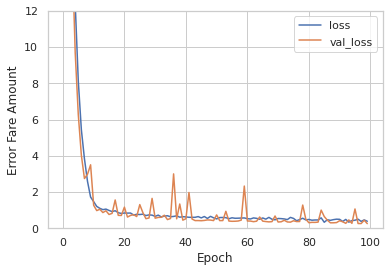

In [38]:
plot_loss(history)

#### Evaluating it on Testing Data

In [39]:
dnn_model.evaluate(X_test, y_test, verbose=1)

129719/129719 [==============================] - 58s 448us/step - loss: 0.2595


0.2595158517360687

In [40]:
y_pred = dnn_model.predict(X_test).flatten()

# Display metrics
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)
print("RMSE: %.3f" % np.sqrt(mse))
r2 = r2_score(y_test, y_pred)
print("R2:", r2)

MSE: 0.2595174825548348
RMSE: 0.509
R2: 0.9969410797556902


### Running the Neural Network Model without `total_amount`

In [41]:
X = upd_taxi_trip_df.drop(columns=['fare_amount', 'total_amount'])
y = upd_taxi_trip_df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [42]:
dnn_model_upd = Sequential()
dnn_model_upd.add(Dense(32, activation='relu', input_shape=(len(X_train.columns),)))
dnn_model_upd.add(Dense(32, activation='relu'))
dnn_model_upd.add(Dense(32, activation='relu'))
dnn_model_upd.add(Dense(1, activation='linear'))

In [43]:
dnn_model_upd.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                2976      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


#### Compiling the Neural Network Model and fitting it on Training Data

In [44]:
dnn_model_upd.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [45]:
history_upd = dnn_model_upd.fit(
            X_train, y_train,
            validation_split=0.2,
            batch_size = 50000,
            callbacks=[callback],
            verbose=1, epochs=100)

Epoch 1/100
155/155 [==============================] - 4s 20ms/step - loss: 134.6747 - val_loss: 84.3540
Epoch 2/100
155/155 [==============================] - 2s 14ms/step - loss: 83.8182 - val_loss: 82.9803
Epoch 3/100
155/155 [==============================] - 2s 14ms/step - loss: 82.1484 - val_loss: 79.5515
Epoch 4/100
155/155 [==============================] - 2s 14ms/step - loss: 75.6524 - val_loss: 42.5130
Epoch 5/100
155/155 [==============================] - 2s 14ms/step - loss: 34.8123 - val_loss: 22.5036
Epoch 6/100
155/155 [==============================] - 2s 14ms/step - loss: 20.9281 - val_loss: 16.6973
Epoch 7/100
155/155 [==============================] - 2s 14ms/step - loss: 15.5114 - val_loss: 11.9521
Epoch 8/100
155/155 [==============================] - 2s 14ms/step - loss: 11.4750 - val_loss: 8.3586
Epoch 9/100
155/155 [==============================] - 2s 14ms/step - loss: 7.8572 - val_loss: 5.4705
Epoch 10/100
155/155 [==============================] - 2s 14ms/st

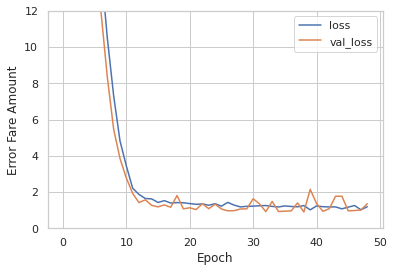

In [46]:
plot_loss(history_upd)

#### Evaluating it on Testing Data

In [47]:
dnn_model_upd.evaluate(X_test, y_test, verbose=1)

129719/129719 [==============================] - 58s 446us/step - loss: 1.3510


1.3509589433670044

In [48]:
y_pred = dnn_model_upd.predict(X_test).flatten()

# Display metrics
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)
print("RMSE: %.3f" % np.sqrt(mse))
r2 = r2_score(y_test, y_pred)
print("R2:", r2)

MSE: 1.3509500872231481
RMSE: 1.162
R2: 0.9840764154685198
